In [1]:
import scipy.ndimage
from numpy.linalg import norm
import pandas as pd
from joblib import Parallel, delayed
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [10]:
np.random.seed(100)

d = 256

s1 = pi # width of the gaussian

t = arange(- d / 2, d / 2)
h = (1 - t ** 2 / s1 ** 2) * exp(- (t ** 2) / (2 * s1 ** 2))
h = h - h.mean()

h_tf = fft.fft(fft.fftshift(h))
opA = lambda u : real(fft.ifft(fft.fft(u) * h_tf))

s = 8 # number of nonzero elements of xsharp

std = 0.1 #0.1 for the ER plot, 0.05 for the deblurring plot

def training_set(n):
    x_train = zeros((d, n))
    idx = random.permutation(d)
    eps_train = np.zeros((d, n))
    for i in range(n):
        eps_train[:, i] = random.normal(0, std, d)
    y_train = zeros((d, n))
    for i in range(n):
        sel = random.permutation(d)
        sel = sel[0 : s]   # indices of the nonzero elements of xsharp
        xsharp = zeros(d)
        xsharp[sel] = sign(randn(s)) * (1 - 0.3 * rand(s))

        x_train[:, i] = xsharp / np.linalg.norm(xsharp, ord=2)
        y_train[:, i] =  opA(x_train[:, i]) + eps_train[:, i]

    return x_train, y_train


N_train = 10000
x_train, y_train = training_set(N_train)  # every element is in a column

In [ ]:
fig, (ax_orig, ax_win, ax_filtered) = plt.subplots(3, 1, sharex=True, figsize=(20, 10), dpi=100)
ax_orig.stem(x_train[:, 0])
ax_orig.set_title('Original pulse', fontsize=20)
ax_orig.set_xlim(0, d - 1)
ax_orig.tick_params(axis='y', labelsize=15)
ax_win.plot(h)
ax_win.set_title('Filter', fontsize=20)
ax_win.margins(0, 0.1)
ax_win.tick_params(axis='y', labelsize=15)
ax_filtered.stem(y_train[:, 0])
ax_filtered.set_title('Blurred, noisy signal', fontsize=20)
ax_filtered.margins(0, 0.1)
ax_filtered.tick_params(axis='y', labelsize=15)
plt.xticks(fontsize=15)
plt.savefig("./blurred_sparse_signal.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

In [5]:
# We compute here D_||.||_1(x, y). Inputs vectors/matrices, outputs number
def breg_dist_l1(x, y): 
    norm_x = norm(x, ord=1, axis=0)
    dot_prod = np.sum(sign(y) * x, axis=0)
    return norm_x - dot_prod

beta = abs(fft.fft(h)).max() ** 2
gamma = 1.3 / beta

# soft thresholding function here:
def st(x, Lambda):
    y = x - x / np.maximum(np.abs(x) / (Lambda * gamma), 1) 
    return y 

def fista(y, lam):
    w = zeros(len(y))
    z = zeros(len(y))
    nor1 = 1
    it = 0
    t_new = 1
    while nor1 >= 1e-6:
        t_old = t_new
        t_new = (1 + np.sqrt(1 + 4 * t_old ** 2)) / 2
        w_old = w.copy()
        z -= gamma * opA(opA(z) - y)
        w = st(z, lam)
        z = w + (t_old - 1.) / t_new * (w - w_old)
        nor1 = norm(w - w_old, ord=1)
        it += 1
    return w


def cvlambda(n, lamb):
    x_tr, y_tr = training_set(n) 
    num_cores = -1  #(-1 uses all available cores)
    
    def calculate_l1_err(la):
        f_lasso = np.array([fista(y, la) for y in y_tr.T])
        distances = breg_dist_l1(x_tr, f_lasso.T)
        return np.average(distances)

    l1_err = Parallel(n_jobs=num_cores)(delayed(calculate_l1_err)(la) for la in lamb)
    l1_err = np.array(l1_err)
    min_index = np.argmin(l1_err)
    return l1_err.min(), lamb[min_index]


def get_lambda_star(lamb):
    num_cores = -1  # You can specify the number of cores (-1 uses all available cores)

    def calculate_l1_err(i):
        f_lasso = np.array([fista(y, lamb[i]) for y in y_train.T])
        distances = breg_dist_l1(x_train, f_lasso.T)
        return np.average(distances)

    l1_err = Parallel(n_jobs=num_cores)(delayed(calculate_l1_err)(i) for i in range(len(lamb)))
    l1_err = np.array(l1_err)
    min_index = np.argmin(l1_err)
    return lamb[min_index], l1_err[min_index]
    

def get_lambda_hat(L_lambda_star, lamb, N_vec, n_it):
    def compute_deltan(i):
        print('n=', N_vec[i])
        Deltan_i = np.zeros(n_it)
        for j in range(n_it):
            cv = cvlambda(N_vec[i], lamb)[0]
            Deltan_i[j] = np.abs(L_lambda_star - cv)
        return Deltan_i
    num_cores = -1  # (-1 uses all available cores)
    results = Parallel(n_jobs=num_cores)(delayed(compute_deltan)(i) for i in range(len(N_vec)))
    Deltan = np.array(results)
    return Deltan

lamb = logspace(-2, 0, num=50)

In [6]:
lambda_star, L_lambda_star = get_lambda_star(lamb)

In [7]:
lambda_star

0.1151395399326447

In [ ]:
# We plot here the ER plot

In [8]:
N_vec = arange(10, 160, 10)
n_it = 30  # The perfect number of iterations is 30

deltalasso = get_lambda_hat(L_lambda_star, lamb, N_vec, n_it)
Deltalasso = np.zeros(np.shape(deltalasso))
for i in range(len(deltalasso)):
    Deltalasso[i] = deltalasso[i] * sqrt(N_vec[i])

n= 10
n= 20
n= 30
n= 40
n= 50
n= 60
n= 70
n= 80
n= 90
n= 100
n= 110
n= 120
n= 130
n= 140


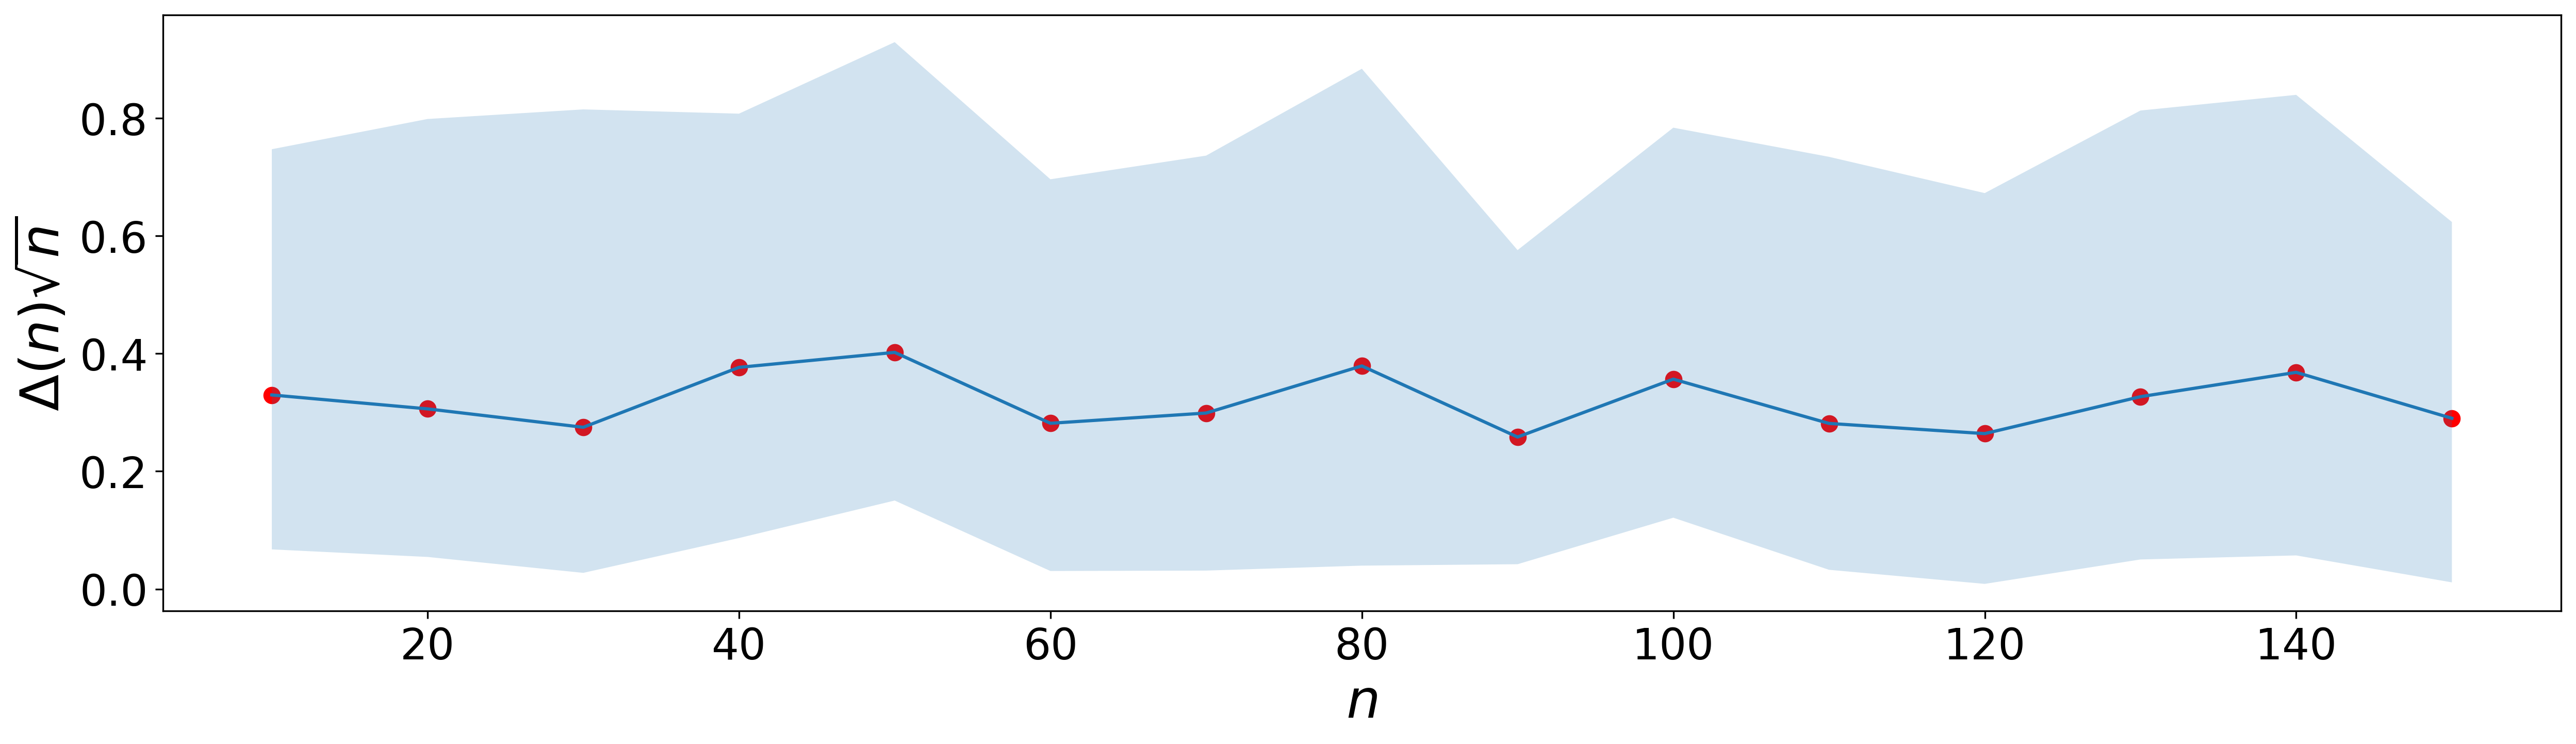

n= 150


In [9]:
dflasso = pd.DataFrame(Deltalasso)
meanlasso = dflasso.mean(axis='columns')
lowerlasso = quantile(Deltalasso, 0.05, axis=1)
upperlasso = quantile(Deltalasso, 0.95, axis=1)

     
# Figures

plt.close('all')
fig, ax1 = plt.subplots(figsize=(20, 5), dpi=300)
ax1.plot(N_vec, meanlasso, '-')
ax1.scatter(N_vec, meanlasso, color='red', s=50)
ax1.fill_between(N_vec, lowerlasso, upperlasso, alpha=0.2)
ax1.set_ylabel(r'$\Delta(n)\sqrt{n}$', fontsize=25)
ax1.set_xlabel(r'$n$', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./ER_lasso_deblurring.pdf", bbox_inches='tight')  # This shud go before show
plt.show(block=False)

In [ ]:
# We test FISTA here with la^, selected with 100 points.

In [ ]:
lambda_hat = cvlambda(100, lamb)[1]

In [ ]:
N_test = 5
x_test, y_test = training_set(N_test)

x = x_test[:, 0]
y = y_test[:, 0]
y_lasso = fista(y, lambda_hat)

fig, (ax_orig, ax_filtered, ax_rec) = plt.subplots(3, 1, sharex=True, figsize=(20, 8), dpi=300)
ax_orig.stem(x)
ax_orig.set_title('Original', fontsize=25)
ax_orig.set_xlim(0, d - 1)
ax_orig.tick_params(axis='y', labelsize=20)
ax_filtered.stem(y)
ax_filtered.set_title('Blurred, noisy', fontsize=25)
ax_filtered.margins(0, 0.1)
ax_filtered.tick_params(axis='y', labelsize=20)
ax_rec.stem(y_lasso)
ax_rec.set_title('Recovered', fontsize=25)
ax_rec.margins(0, 0.1)
ax_rec.tick_params(axis='y', labelsize=20)
plt.subplots_adjust(hspace=0.5) 
plt.xticks(fontsize=20)
plt.savefig("./sparse_deblurring.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()